In [34]:
import torch
from random import shuffle
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from matplotlib import pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [61]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"

] 
x_train_path = "shuffled_x_train_data.csv"
y_train_path = "shuffled_y_train_data.csv"
x_test_path = "shuffled_x_test_data.csv"
y_test_path = "shuffled_y_test_data.csv"

# Hyper-parameters 
num_classes = 6
num_epochs = 10
train_batch_size = 125
test_batch_size = 50
learning_rate = 0.00005

input_size = 36
sequence_length = 32
hidden_size = 64
num_layers = 1

In [9]:
device

device(type='cpu')

In [45]:
x_train = pd.read_csv(x_train_path, sep="\t", dtype=np.float32)
x_test = pd.read_csv(x_test_path, sep="\t", dtype=np.float32)
y_train = pd.read_csv(y_train_path, sep="\t", dtype=np.int_)
y_test = pd.read_csv(y_test_path, sep="\t", dtype=np.int_)

In [49]:
x_test = x_test[:-32]
y_test = y_test[:-1]

In [66]:
y_train.shape

(22625, 1)

In [18]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [19]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

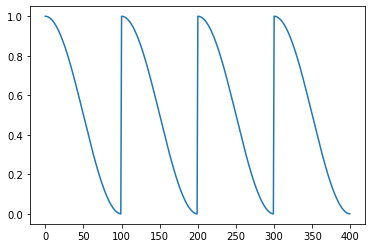

In [22]:
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)

In [26]:
def chunker(x_seq, y_seq, seq_size, batch_size):
    for batch_pos in range(0, len(y_seq), batch_size):
        x_batch = list()
        for pos in range(batch_size):
            # print(x_seq.iloc[pos*seq_size:pos*seq_size + seq_size])
            x_batch.append(x_seq.iloc[pos*seq_size:pos*seq_size + seq_size].values)
        
        yield torch.tensor(x_batch), torch.flatten(torch.tensor(y_seq.iloc[batch_pos:batch_pos + batch_size].values))
        

In [37]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        return h0, c0

In [62]:
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)

n_total_steps = int(y_train.shape[0] / train_batch_size)
best_acc = 0
patience, trials = 100, 0

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
sched = CyclicLR(optimizer, cosine(t_max=n_total_steps * 2, eta_min=learning_rate/100))

In [63]:
print('Start model training')


for epoch in range(1, num_epochs + 1):
    correct = 0
    for i, (x_batch, y_batch) in enumerate(chunker(x_train, y_train, sequence_length, train_batch_size)): 
        model.train() 
        y_batch = y_batch.to(device)
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        

        outputs = model(x_batch)       
        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()
        sched.step()
        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    model.eval()
    correct, total = 0, 0
    for x_val, y_val in chunker(x_test, y_test, sequence_length, test_batch_size):
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
            
    acc = correct / total

    print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Start model training
Epoch [2/10], Step [10/181], Loss: 1.7885
Epoch [2/10], Step [20/181], Loss: 1.7851
Epoch [2/10], Step [30/181], Loss: 1.7910
Epoch [2/10], Step [40/181], Loss: 1.7762
Epoch [2/10], Step [50/181], Loss: 1.7783
Epoch [2/10], Step [60/181], Loss: 1.7730
Epoch [2/10], Step [70/181], Loss: 1.7802
Epoch [2/10], Step [80/181], Loss: 1.7656
Epoch [2/10], Step [90/181], Loss: 1.7629
Epoch [2/10], Step [100/181], Loss: 1.7661
Epoch [2/10], Step [110/181], Loss: 1.7515
Epoch [2/10], Step [120/181], Loss: 1.7711
Epoch [2/10], Step [130/181], Loss: 1.7559
Epoch [2/10], Step [140/181], Loss: 1.7538
Epoch [2/10], Step [150/181], Loss: 1.7701
Epoch [2/10], Step [160/181], Loss: 1.7415
Epoch [2/10], Step [170/181], Loss: 1.7478
Epoch [2/10], Step [180/181], Loss: 1.7338
Epoch:   1. Loss: 1.7380. Acc.: 22.82%
Epoch 1 best model saved with accuracy: 22.82%
Epoch [3/10], Step [10/181], Loss: 1.7727
Epoch [3/10], Step [20/181], Loss: 1.7562
Epoch [3/10], Step [30/181], Loss: 1.7689
Ep

KeyboardInterrupt: 